In [72]:
from pathlib import Path      

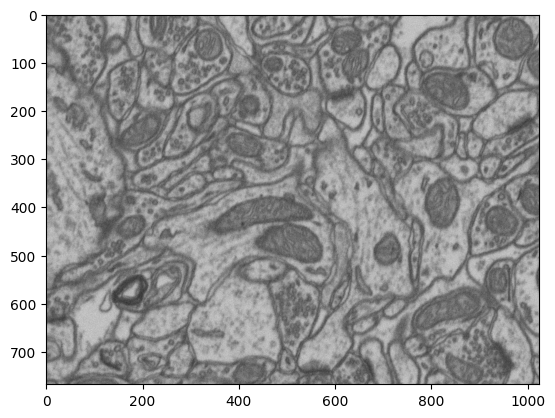

In [115]:
import pickle
from re import A

tnia_images_path = Path(r"D:\images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_04_09_SAM_training')
pickle_name = parent_path / 'training_groundtruth2.pkl'

with open(pickle_name, 'rb') as f:
    data = pickle.load(f)

results = data['results']

for result in results:
    result['image']=data['image']

import matplotlib.pyplot as plt
plt.imshow(result['image'])



1
192
192


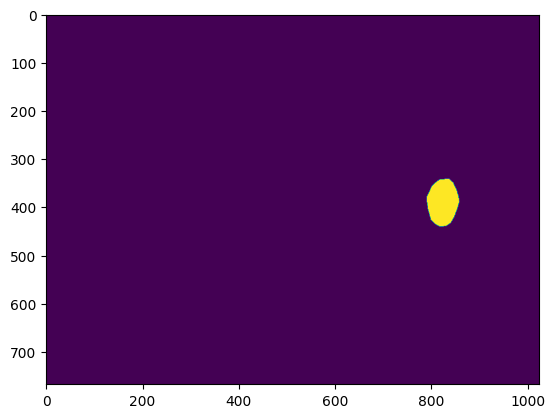

In [116]:
i =0


for r in results:
    i = i+1
    #print(r['point_coords'],r['segmentation'].max()) 
    if r['segmentation'].max() == 0:
        continue
    else:
        binary = r['segmentation']
        break
print(i)
plt.imshow(binary)

# sub sample results by 2
print(len(results))
#results = results[1::2]
print(len(results))



In [118]:
# sort point point_coords
results = sorted(results, key=lambda x: x['point_coords'][0])

for r in results:
    print(r['point_coords'],r['segmentation'].max())

[[64.0, 48.0]] False
[[64.0, 48.0]] False
[[64.0, 48.0]] False
[[64.0, 144.0]] False
[[64.0, 144.0]] False
[[64.0, 144.0]] False
[[64.0, 240.0]] False
[[64.0, 240.0]] False
[[64.0, 240.0]] False
[[64.0, 336.0]] False
[[64.0, 336.0]] False
[[64.0, 336.0]] False
[[64.0, 432.0]] False
[[64.0, 432.0]] False
[[64.0, 432.0]] False
[[64.0, 528.0]] False
[[64.0, 528.0]] False
[[64.0, 528.0]] False
[[64.0, 624.0]] False
[[64.0, 624.0]] False
[[64.0, 624.0]] False
[[64.0, 720.0]] False
[[64.0, 720.0]] False
[[64.0, 720.0]] False
[[192.0, 48.0]] False
[[192.0, 48.0]] False
[[192.0, 48.0]] False
[[192.0, 144.0]] False
[[192.0, 144.0]] False
[[192.0, 144.0]] False
[[192.0, 240.0]] True
[[192.0, 240.0]] True
[[192.0, 240.0]] True
[[192.0, 336.0]] False
[[192.0, 336.0]] False
[[192.0, 336.0]] False
[[192.0, 432.0]] True
[[192.0, 432.0]] True
[[192.0, 432.0]] True
[[192.0, 528.0]] False
[[192.0, 528.0]] False
[[192.0, 528.0]] False
[[192.0, 624.0]] False
[[192.0, 624.0]] False
[[192.0, 624.0]] False
[

In [26]:
filtered = [r for r in results if r['segmentation'].max() == 0]

print(len(results), len(filtered))

192 165


In [27]:
results = filtered

[[832.0, 336.0]]


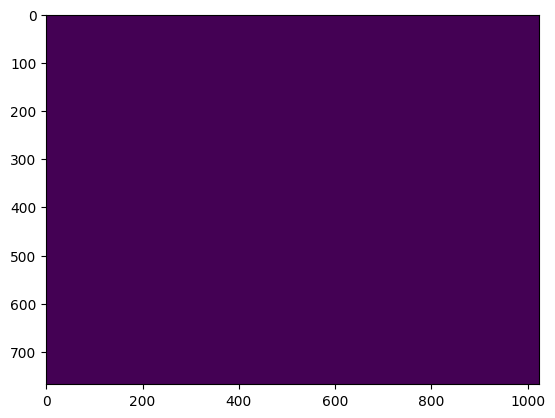

In [28]:
test = results[0]
mask = test['segmentation']
point = test['point_coords']

print(point)

plt.imshow(mask)



In [29]:
results=results[0:1]

In [90]:
from segment_everything.stacked_label_dataset import StackedLabelDataset
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
dataset = StackedLabelDataset(results, processor)

In [91]:
example = dataset[0]
for k,v in example.items():
  print(k,v.shape)

print()
print('original sizes', example['original_sizes'])
print('input point', example['input_points'])

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 2])
ground_truth (768, 1024)

original sizes tensor([ 768, 1024])
input point tensor([[832., 432.]], dtype=torch.float64)


In [92]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)

In [93]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [94]:
from segment_anything import SamPredictor, sam_model_registry
from segment_everything.util import get_weights_path

sam_model = sam_model_registry[model_type](checkpoint=get_weights_path('vit_b'))
sam_model.to(device)
test=sam_model.train()

In [95]:
import torch
from segment_everything.dice import DiceLoss

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 0.00001
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCEWithLogitsLoss()
#loss_fn = DiceLoss()

import monai
#loss_fn = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [127]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(sam_model.image_encoder.img_size)

num_epochs = 50
losses = []

for epoch in range(num_epochs):
    print('epoch', epoch)

    epoch_losses = []
    for batch in train_dataloader:

        
        input_image = batch['pixel_values'].to(device)
        original_input_size = batch['original_sizes'][0]
        input_size = batch['reshaped_input_sizes'][0]
        input_size = tuple(input_size)
        #print('original_image_size',original_input_size)
        #print('input_size',input_size)
        #print(input_image.shape)
        
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)   

            #prompt_points = batch['input_points']
            #print('before transform',prompt_box)
            #print('after transform',box)
            points_torch = torch.as_tensor(batch['input_points'], dtype=torch.float, device=device)
            #points_torch = points_torch[None, :]
            #print('batch input points', batch['input_points'])
            #print('points_torch', points_torch)
            
            
            #points_label = torch.as_tensor(1, dtype=torch.float, device=device)
            points_label = torch.tensor([1,],device=device)
            points_label = points_label[None, :]
            #print('label', points_label)
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=[points_torch,points_label],
            boxes=None,
            masks=None,
            )
        
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        #print('low res masks shape',low_res_masks.shape)

        #upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        upscaled_masks = sam_model.postprocess_masks(low_res_masks, (768,1024), (768, 1024)).to(device)
        
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        #binary_mask = normalize(threshold(low_res_masks, 0.0, 0))
        gt_binary_mask = batch['ground_truth'].unsqueeze(0).to(device).float()
        gt_binary_mask = torch.as_tensor(gt_binary_mask > 0, dtype=torch.float32)
        gt_binary_mask[gt_binary_mask == 0] = -1
        
        #print('upscaled masks size', upscaled_masks.size())
        #print('binary mask size',binary_mask.size())
        #print('gt_binary_mask size',gt_binary_mask.size())
        #print('image min max', input_image.max(), input_image.min())
        #print('binary min max',binary_mask.max(), binary_mask.min())
        #print()
        #print('gt_binary_mask shape',gt_binary_mask.shape)

        loss = loss_fn(upscaled_masks, gt_binary_mask)
        #loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()

        
        #print('gt_min_max',gt_binary_mask.max(), gt_binary_mask.min())
        #print(loss)
        #print()

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        '''
        for name, param in sam_model.named_parameters():
            if param.grad is not None:
                print(f"Gradient norm of {name}: {param.grad.norm().item()}")
        '''
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
        
        
 

epoch 0
EPOCH: 0
Mean loss: 0.0003641767728292204
epoch 1
EPOCH: 1
Mean loss: 0.00033923237174349197
epoch 2
EPOCH: 2
Mean loss: 0.000292245659039736
epoch 3
EPOCH: 3
Mean loss: 0.00032883800483318737
epoch 4
EPOCH: 4
Mean loss: 0.00045559761686793837
epoch 5
EPOCH: 5
Mean loss: 0.00038760528739582395
epoch 6
EPOCH: 6
Mean loss: 0.00027326297599946275
epoch 7
EPOCH: 7
Mean loss: 0.0002727031911812598
epoch 8
EPOCH: 8
Mean loss: 0.0002842542960005782
epoch 9
EPOCH: 9
Mean loss: 0.00027066695872690616
epoch 10
EPOCH: 10
Mean loss: 0.0002651537270897582
epoch 11
EPOCH: 11
Mean loss: 0.00029841482552228626
epoch 12
EPOCH: 12
Mean loss: 0.0003109659117323342
epoch 13
EPOCH: 13
Mean loss: 0.00030640320059660553
epoch 14
EPOCH: 14
Mean loss: 0.00029696624900073704
epoch 15
EPOCH: 15
Mean loss: 0.00024174825165346192
epoch 16
EPOCH: 16
Mean loss: 0.00030404568765144785
epoch 17
EPOCH: 17
Mean loss: 0.0005673391821593062
epoch 18
EPOCH: 18
Mean loss: 0.0003067975340229623
epoch 19
EPOCH: 19
Mea

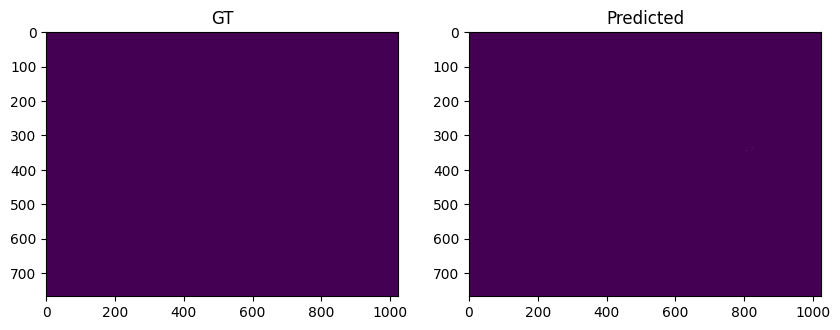

In [87]:
from tnia.plotting.plt_helper import imshow_multi2d

gt_binary_mask_ = gt_binary_mask.detach().cpu().numpy().squeeze()
binary_mask_ = binary_mask.detach().cpu().numpy().squeeze()

fig = imshow_multi2d([gt_binary_mask_, binary_mask_], ['GT', 'Predicted'], 1, 2)

In [123]:
# Save the model's state dictionary to a file
torch.save(sam_model.state_dict(), parent_path / "mito_model_checkpoint4.pth")

In [124]:
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator

In [128]:
import numpy as np
test_image = data['image']
#test_image = np.stack([test_image,test_image,test_image],axis=-1)
generator = SamAutomaticMaskGenerator(sam_model, points_per_side=8, pred_iou_thresh=0.1, stability_score_thresh=0.1)#, box_nms_thresh=1, )
results = generator.generate(test_image)
print(len(results))


10


In [129]:
import napari
from  napari_segment_everything import segment_everything
viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(test_image, results)
viewer.add_labels(data['binary'])


EmitLoopError: 

While emitting signal 'magicgui.widgets.ComboBox.changed', a AttributeError occurred in a callback:

  Signal emitted at: c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\magicgui\widgets\bases\_value_widget.py:71, in _on_value_change
    >  self.changed.emit(value)

  Callback error at: C:\Users\bnort\work\ImageJ2022\tnia\napari-segment-everything\src\napari_segment_everything\segment_everything.py:426, in load_image
    >  self.viewer.refresh()

    Local variables:
       im_layer = <Image layer 'image' at 0x142d8e39060>
       image = array([[[102, 102, 102],
        [132, 132, 132],
        [1...
       max_area = 786432
       i = 0

See AttributeError above for original traceback.

area 1906 785906
label_num 1 10
solidity 0.9119635277472096 0.9993311564127604
circularity 0.5173816313622015 0.8762892106277744
mean_intensity 105.1447692849595 135.71731097612184
10th_percentile_intensity 87.0 96.0
mean_hue 0.0 0.0
mean_saturation 0.0 0.0
predicted_iou 0.4179845452308655 0.8569557666778564
stability_score 0.5270491242408752 0.9566978216171265


<Labels layer 'Labels' at 0x14330364460>

In [ ]:
generator = SamAutomaticMaskGenerator(sam_model, points_per_side=None, pred_iou_thresh=0, stability_score_thresh=0, point_grids=[np.array([[623,51]])])
result = generator.generate(test_image)
print(len(result))

for r in result:
    print(r['predicted_iou'],r['stability_score'])
    print()

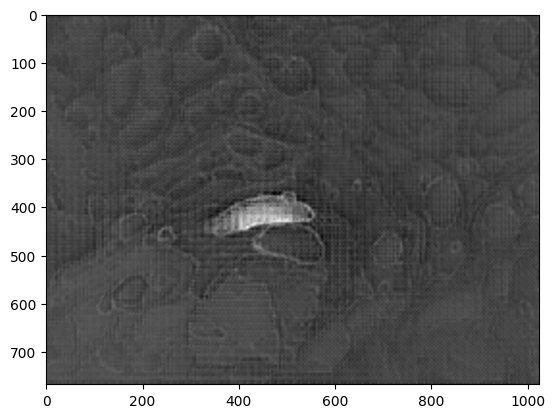

In [111]:
from segment_anything import SamPredictor 
predictor = SamPredictor(sam_model)
predictor.set_image(test_image)

points = np.array([[448,431]])
mask, feedback, logits = predictor.predict(point_coords=points, point_labels=[1], return_logits=True, multimask_output=False)

plt.imshow(mask[0,:,:], cmap='gray')



In [112]:
binary = data['binary']

In [113]:
import napari
viewer = napari.Viewer()
viewer.add_image(mask[0,:,:])
viewer.add_image(test_image)
viewer.add_labels(binary)


<Labels layer 'binary' at 0x14303883820>

In [ ]:
results_ = results.copy()
from skimage.measure import label
labels = label(data['binary'])

from segment_everything.util import labels_to_results_from_point_coords
labels_to_results_from_point_coords(labels, results)

pickle_name = parent_path / 'training_groundtruth2.pkl'
    
project = {'results': results_, 'image': test_image, 'binary': data['binary']}

print(pickle_name)
with open(pickle_name, 'wb') as f:
    pickle.dump(project, f)